# M3 - Delivery 2

## Created By: Laura M., Andreu J.R., Aitor S.

The main objective in this second delivery of the M3-Machine Learning for Computer Vision Module is to solve an image classification problem by using the Bag of Words model, Cross-Validation and Spatial Pyramids. For image classification, Support Vector Machine(SVM) classifier has been implemented offering different kernel configurations: Linear, RBF, Polynomial and Histogram Intersection. 

The program starts by computing the Scale Invariant Feature Transform (SIFT). The obtained descriptors are clustered using the k-means clustering algorithm and represented by a visual keyword (label). Then, the Spatial Pyramids algorithm is applied and the descriptors histogram(visual words) is computed. Finally, the SVM classifier is fitted with the histogram to train a model using a cross-validation technique. To test the model performance, the accuracy is computed using a completly new test dataset.

Hereunder, the Python scripts used for the second delivery are enclosed.

It is important to remark that the working directory -path- in which the MIT_split dataset images are stored -as train and test-, should be used in order to execute the following code.

### Pyramid_words.py

This script contains the method used to compute the visual words, taking into account the pyramid levels and descriptors of the image.

In [3]:
import numpy as np
from sklearn.preprocessing import normalize


def pyramid_visual_word(pyramid_descriptors, codebook, k_codebook, descriptors, norm_method):
    visual_words = []
    
    for pyramid_level in pyramid_descriptors:
        
        for im_pyramid, j in zip(pyramid_level, np.arange(len(pyramid_level))):
            words_hist = np.array([])
            
            for sub_im in im_pyramid:

                sub_words = codebook.predict(sub_im)
                sub_words_hist = np.bincount(sub_words, minlength=k_codebook)
                sub_words_hist = normalize(sub_words_hist.reshape(-1,1), norm= norm_method, axis=0).reshape(1,-1)
                words_hist = np.append(words_hist, sub_words_hist) 
                
            if (len(visual_words) < len(descriptors)):
                visual_words.append(words_hist)
               
            else:
                visual_words[j] = np.append(visual_words[j], words_hist)
    
    return np.array(visual_words, dtype='f')             
            

### Classifier.py

This script offers the methods needed to initialize different classifiers such as KNN or SVM. Also, the method for computing the Histogram Intersection Kernel can be found. 

In [4]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler


def init_classifier_knn(knn_param):

    return KNeighborsClassifier(
            n_neighbors=knn_param["k_classifier"], 
            n_jobs=-1, 
            metric=knn_param["distance_method"])

def init_classifier_svm(svm_param):
    
    models = (
            (svm.SVC(kernel=svm_param["kernel"][0],
                     C=svm_param["C_linear"]),
             "linear1"),
            (svm.LinearSVC(C=svm_param["C_linear2"]), 
             "linear2"),
            (svm.SVC(kernel=svm_param["kernel"][1],
                     gamma=svm_param["gamma"], 
                     C=svm_param["C_rbf"]), 
             "rbf"),
            (svm.SVC(kernel=svm_param["kernel"][2], 
                     degree=svm_param["degree"],
                     gamma=svm_param["gamma_poly"], 
                     C=svm_param["C_poly"]), 
             "poly"),
            (svm.SVC(kernel=svm_param["kernel"][3],
                     C=svm_param["C_inter"]), 
             "inter")
            )
        
    return models


def histogram_intersection(set1, set2):

    set1 = abs(set1)
    set2 = abs(set2)

    inter = np.zeros((set1.shape[0], set2.shape[0]))

    for col in range(set1.shape[1]):
        col_1 = set1[:, col].reshape(-1, 1)
        col_2 = set2[:, col].reshape(-1, 1)

        inter += np.minimum(col_1, col_2.T)
     
    return inter
    
    
def compute_intersection_kernel(data_test, data_train):

    scld = StandardScaler().fit(data_train)
    scaled_train = scld.transform(data_train)
    scaled_test = scld.transform(data_test)

    return histogram_intersection(scaled_test, scaled_train)


def compute_regular_kernel(data_test, data_train):
    return data_test

### Visualization.py

This script offers two methods to plot the results: (1) accuracy vs time plot and (2) confusion matrix plot. 

In [5]:
from matplotlib import pyplot as plt
import itertools
import numpy as np

def plot_accuracy_vs_time(x, y1, y2, feature_name, title):
    """
    This function plots a doble axis figure.
    Feature name and title can be modified to be plot
    """  
    fig, ax1 =plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('accuracy', color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('time (s)', color=color)  
    ax2.plot(x,y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()     

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### BagofVisualWords_python3x.py

This is the most significant script of the delivery. It contains several methods such as the detectors, the descriptors pyramid, the BOW or the cross validation computation.

In [6]:
import cv2
import numpy as np
import pickle
import time

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import sys
from sklearn.model_selection import train_test_split, GridSearchCV


def open_pkl(pkl_file):
    """
    This function opens pkl files providing file name on WD.
    """
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)
    return data


def compute_detector(sift_step_size, sift_scale, n_features=300):
    """
    Computes Sift detector object.
    Computes mesh of KPs using a custom step size and scale value(s).
    Points are shifted by sift_step_size/2 in order to avoid points on 
    image borders
    """
    SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=n_features)

    if not isinstance(sift_scale, list):
        sift_scale = [sift_scale]

    kpt = [cv2.KeyPoint(x, y, scale) for y in
           range(int(sift_step_size / 2) - 1, 256 - int(sift_step_size / 2), sift_step_size) for x in
           range(int(sift_step_size / 2) - 1, 256 - int(sift_step_size / 2), sift_step_size) for scale in sift_scale]

    return (SIFTdetector, kpt)


def compute_des_pyramid(dataset_desc, pyramid_level, kpt, img_px=256):
    """
    Computes Pyramid divison of the kp descriptors dataset
    It uses KPs values to descriminate to which level each descriptor belongs
    """
    div_level = int(2 ** (pyramid_level))
    pyramid_res = img_px / div_level
    pyramid_desc = []

    for image_desc in dataset_desc:
        im_pyramid_desc = []
        # axis 0 divisions
        for n in range(1, div_level + 1):
            # axis 1 divisions
            for m in range(1, div_level + 1):
                sub_desc = []
                for kp_desc, kp in zip(image_desc, kpt):
                    x, y = kp.pt
                    # sub resolution area
                    if (((n - 1) * pyramid_res <= x < n * pyramid_res) and
                            ((m - 1) * pyramid_res <= y < m * pyramid_res)):
                        sub_desc.append(kp_desc)

                im_pyramid_desc.append(np.array(sub_desc, dtype='f'))

        pyramid_desc.append(im_pyramid_desc)

    return pyramid_desc


def compute_BOW(train_images_filenames, dense, SIFTdetector, kpt,
                k_codebook, pyramid_level, norm_method):
    train_descriptors = []
    # Compute SIFT descriptors for whole DS 
    for filename in train_images_filenames:
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        if dense:
            (_, des) = SIFTdetector.compute(gray, kpt)
        else:
            (_, des) = SIFTdetector.detectAndCompute(gray, None)
            # Creates a list with all the descriptors
        train_descriptors.append(des)

    # Descriptors are clustered with KMeans (whole image, e.g pyramid_level = 0)
    descriptors = np.vstack(train_descriptors)

    codebook = MiniBatchKMeans(n_clusters=k_codebook, batch_size=k_codebook * 20,
                               compute_labels=False, reassignment_ratio=10 ** -4,
                               random_state=42)
    codebook.fit(descriptors)

    # Pyramid Representation of n Levels
    pyramid_descriptors = []

    while pyramid_level >= 0:
        pyramid_descriptors.append(compute_des_pyramid(train_descriptors, pyramid_level, kpt))
        pyramid_level -= 1

    # Create visual words with normalized bins for each image and subimage
    # After individually normalized, bins are concatenated for each image

    visual_words = pyramid_visual_word(pyramid_descriptors, codebook, k_codebook, train_descriptors, norm_method)

    return codebook, visual_words


def test_BOW(test_images_filenames, dense, SIFTdetector, kpt, k_codebook, pyramid_level, codebook):
    test_descriptors = []

    for filename in test_images_filenames:
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        if dense:
            (_, des) = SIFTdetector.compute(gray, kpt)
        else:
            (_, des) = SIFTdetector.detectAndCompute(gray, None)

        test_descriptors.append(des)

    # Pyramid Representation of n Levels            
    pyramid_descriptors = []

    while pyramid_level >= 0:
        pyramid_descriptors.append(compute_des_pyramid(test_descriptors, pyramid_level, kpt))
        pyramid_level -= 1

    # Create visual words with normalized bins for each image and subimage
    # After individually normalized, bins are concatenated for each image
    visual_words_test = pyramid_visual_word(pyramid_descriptors, codebook, k_codebook, test_descriptors, norm_method)

    return visual_words_test


def compute_accuracy_labels(test_labels, train_labels, test_data, clf):

    accuracy = 100 * clf.score(test_data, test_labels)
    predicted_labels = clf.predict(test_data)
    unique_labels = list(set(train_labels))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_labels, predicted_labels, labels=unique_labels)

    return accuracy, cnf_matrix, unique_labels


def cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook, dense, 
                     pyramid_level, norm_method, compute_kernel, classifier):
    splits_accuracy = []
    splits_time = []

    for number, (train_index, test_index) in enumerate(skf.split(X, y)):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        start = time.time()


        (codebook, visual_words) = compute_BOW(x_train, dense, SIFTdetector, kpt,
                                               k_codebook, pyramid_level, norm_method)
        bow_time = time.time()

        # Compute kernel for classifier
        # If not intersection, kernelMatrix = visual_words
        kernel_matrix = compute_kernel(visual_words, visual_words)

        classifier.fit(kernel_matrix, y_train)

        visual_words_test = test_BOW(x_test, dense, SIFTdetector, kpt, k_codebook,
                                     pyramid_level, codebook)

        # Compute kernel for classifier
        # If not intersection, kernelMatrix = visual_words
        kernel_matrix_test = compute_kernel(visual_words_test, visual_words)

        accuracy, cnf_matrix, unique_labels = compute_accuracy_labels(y_test, y_train, 
                                                                      kernel_matrix_test, 
                                                                      classifier)

        class_time = time.time()
        ttime = class_time - start

        # Add accuracy for each validation step
        splits_accuracy.append(accuracy)
        splits_time.append(ttime)

        #print("\nAccuracy for split", number, ":", accuracy, "\nTotal Time: ", class_time - start,
        #      "\nBOW Time: ", bow_time - start, "\nClassification Time: ", class_time - bow_time)

        # Plot normalized confusion matrix
        # np.set_printoptions(precision=2)
        # plot_confusion_matrix(cnf_matrix, classes=unique_labels,
        #                      normalize=True,
        #                      title='Normalized confusion matrix')
        
    return splits_accuracy, splits_time

# Playing starts here
After all the methods have been declared, it is time to start finding our best values for our parameters and the differences between different methods in order to classify these images. 


### Variable Definition

The variables are initialized using the default values from last week.

In [8]:
# Determines total number of kps in an given image (set composed of 256x256px img)
sift_step_size = 20

# List providing scale values to compute at each kp
sift_scale = [20]

# Dense/Normal Sift 
dense = True

# Number of clusters in KMeans, size of codebook (words)
k_codebook = 128

type_classifier = "KNN"

knn_dict =	{
  "k_classifier": 5,
  "distance_method": "euclidean",
}

svm_dict ={
    "kernel": ["linear", "rbf", "poly", "precomputed"],
    "C_linear": 0.1,
    "C_linear2": 0.1,
    "C_rbf": 1,
    "C_poly": 0.1,
    "C_inter": 1,
    "gamma": 0.001,
    "degree": 1,
}

# Number of pyramid levels used
pyramid_level = 0
# CrosValidation division kfold
number_splits = 3
# Intersection Kernel for SVN 
intersection = False
# Distance method used in order to normalize bincounts for the BoW
norm_method = "l2"


In [9]:
# Prepare files from DS for training and creates Folds
train_images = open_pkl('train_images_filenames.dat')
train_labels = open_pkl('train_labels.dat')

X = np.array(train_images)
y = np.array(train_labels)


### SIFT

First of all, based on the feedback received from last week, SIFT parameters are going to be revisited, now with a proper cross-validation scheme.

Step size is iterated over using power distribution (4, 8, 16, 32...). 

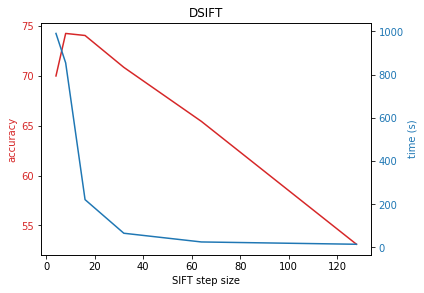

In [14]:
# Creates instance for Kfold
skf = StratifiedKFold(n_splits=number_splits, random_state=42, shuffle=True)
# Loads KNN classifier
classifier = init_classifier_knn(knn_dict)

accuracy_list = []
time_list = []

sift_step_size_iterations = [2**n for n in range(2,8)]

for sift_step_size in sift_step_size_iterations:
    (SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
    accuracy_validation, time_validation = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, compute_regular_kernel, classifier)
    # Append for the different testing values
    accuracy_list.append(np.average(accuracy_validation))
    time_list.append(np.average(time_validation))


plot_accuracy_vs_time(sift_step_size_iterations, accuracy_list, time_list,
                      feature_name='SIFT step size', title="DSIFT")

As it can be observed, the best value for the step size lies around 16.

In [10]:
sift_step_size = 16

Another approach missing in previous week was to test multiply scales at the same time, therefore here, different combinations for scales are goint to be tested. First, we are going to find the best values (individually) for scales, them, we are goint to add them together. 

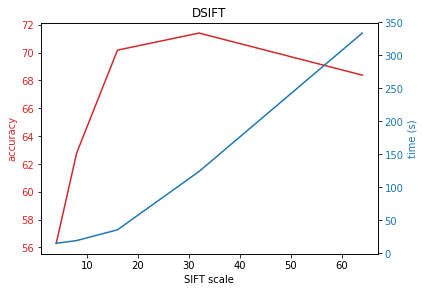

In [17]:
accuracy_list = []
time_list = []

sift_scale_iterations = [2**n for n in range(2,7)]

for sift_scale in sift_scale_iterations:
    (SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
    accuracy_validation, time_validation = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, compute_regular_kernel, classifier)
    # Append for the different testing values
    accuracy_list.append(np.average(accuracy_validation))
    time_list.append(np.average(time_validation))
    
plot_accuracy_vs_time(sift_scale_iterations, accuracy_list, time_list,
                      feature_name='SIFT scale', title="DSIFT")

The best values for the Sift scale with a fixed step (from greater to lower accuracy): 32, 16, 8, 64, 4, 128 
Let's try now to convine them.

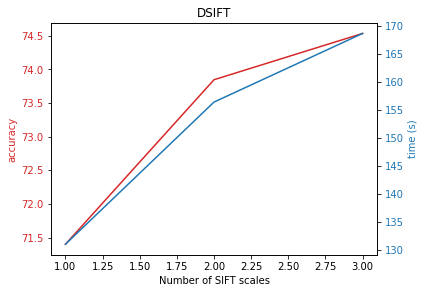

In [18]:
accuracy_list = []
time_list = []

sift_scale_iterations = [[32],[16,32],[8, 16, 32]]

for sift_scale in sift_scale_iterations:
    (SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
    accuracy_validation, time_validation = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, compute_regular_kernel, classifier)
    # Append for the different testing values
    accuracy_list.append(np.average(accuracy_validation))
    time_list.append(np.average(time_validation))
    
plot_accuracy_vs_time(np.arange(1,len(sift_scale_iterations)+1), accuracy_list, time_list,
                      feature_name='Number of SIFT scales', title="DSIFT")

It has been shown that multi-sacle approach benefits our accuracy, however, using more than two or three scales would not affect much on accuracy but would greatly increasing time. Therefore from now on the scale would be set to:

In [11]:
sift_scale = [16, 32]

### Codebook - Kmeans

As suggested in the last review, used k_codebooks have been expanded to larger values. Our starting point will be 2^n with n = 6 (k_codebook = 64) and our ending point will be in n = 12 (k_codebook = 4096).


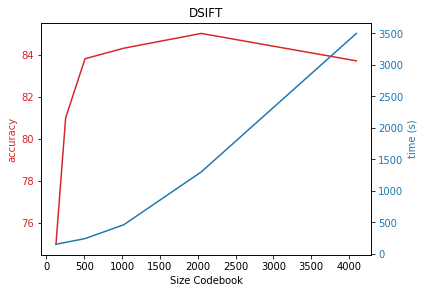

In [22]:

accuracy_list = []
time_list = []

codebook_iterations = [2**n for n in range(6,12)]

for k_codebook in codebook_iterations:
    (SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
    accuracy_validation, time_validation = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, compute_regular_kernel, classifier)
    # Append for the different testing values
    accuracy_list.append(np.average(accuracy_validation))
    time_list.append(np.average(time_validation))

plot_accuracy_vs_time(codebook_iterations, accuracy_list, time_list,
                      feature_name='Size Codebook', title="DSIFT")

As it can be seen, the best results are obtained by using a k_codebook = 2048. However because of small difference in results but greater in time we will stay with K = 1024 from now on.

In [12]:
k_codebook = 1024

### Norm Methods
The normalization applied is used to scale the input vectors individually to the unit norm (vector length). As seen, 'L1' 
normalization provides poor results compared with 'L2' and 'max' normalizations. Although, these two normalizations provide
too similar results so 'l2' has been chosen as a normalization mode. 

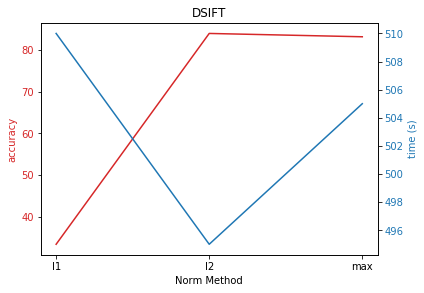

In [23]:
accuracy_list = []
time_list = []

norm_iterations = ['l1', 'l2', 'max'] 

for norm_method in norm_iterations:
    (SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
    accuracy_validation, time_validation = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, compute_regular_kernel, classifier)
    accuracy_list.append(np.average(accuracy_validation))
    time_list.append(np.average(time_validation))   
    
plot_accuracy_vs_time(norm_iterations, accuracy_list, time_list,
                      feature_name='Norm Method', title="DSIFT")

In [13]:
norm_method = 'l2'

### Pyramid Levels
Once on the parameters from last week has been revisited, including different norm methods for woriking out the distances, pyramids are introduced so that spatial information is not lost. Therefore, we are going to compute the boost in performance by introducing different levels of pyramids in our pipeline. 

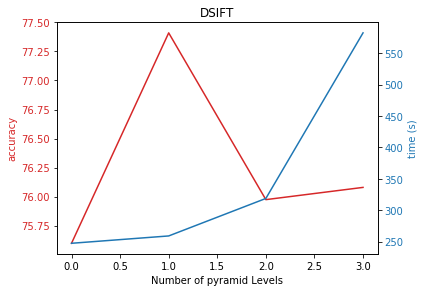

In [30]:
accuracy_list = []  
time_list = []

pyramid_level_iterations = np.arange(4)

for pyramid_level in pyramid_level_iterations:
    (SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
    accuracy_validation, time_validation = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, compute_regular_kernel, classifier)
    # Append for the different testing values
    accuracy_list.append(np.average(accuracy_validation))
    time_list.append(np.average(time_validation))
    
plot_accuracy_vs_time(pyramid_level_iterations, accuracy_list, time_list,
                      feature_name='Number of pyramid Levels', title="DSIFT")

Introducing pyramids improved our results, however it just dit for pyramid of level 1, when going further the results did not kept improving, therefore:

In [14]:
pyramid_level = 1

## Kernel SVM

The parameters for the SVM kernels have been found differently. First, the parameters for each kernel are found using the GridSearchCV method from sklearn. GridSearchCV allows finding the best classifier for the current training data. After the possible optimal parameters are found, all the program will be executed for each one of the kernels to see which one performs the best classification.

In order to run the GridSearchCV, we require the visual_words obtained after computing SIFT descriptors and applying the KMeans clustering. This process is run in the code below:

In [15]:
(SIFTdetector, kpt) = compute_detector(sift_step_size, sift_scale)
(codebook, visual_words) = compute_BOW(train_images, dense, SIFTdetector, kpt, k_codebook, pyramid_level, norm_method)

### 1. Training Parameters for each Kernel

Now, we are going to train the SVM kernels with different parameters to find the best ones for our training data.

### Linear Kernel: OVO

In [16]:
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 0.55, 0.65, 0.75, 0.8, 1, 10, 100]}

 
# Make grid search classifier
clf_grid = GridSearchCV(svm.SVC(kernel='linear', decision_function_shape='ovo'), param_grid, verbose=1, n_jobs=4)
 
# Train the classifier
clf_grid.fit(visual_words, train_labels)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  2.4min finished


Best Parameters:
 {'C': 0.75}
Best Estimators:
 SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Linear Kernel: OVR

In [17]:
param_grid = {'C': [0.1, 0.55, 0.65, 0.75, 0.8, 0.9 ,1, 10, 100]}
 
clf_grid = GridSearchCV(svm.LinearSVC(), param_grid, verbose=1, n_jobs=4)
 
clf_grid.fit(visual_words, train_labels)
 
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:    5.6s finished


Best Parameters:
 {'C': 0.1}
Best Estimators:
 LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


### RBF Kernel

In [18]:
param_grid = {'C': [0.1, 0.55, 0.65, 0.75, 0.8, 0.9 ,1, 10, 100], 
              'gamma': [0.1, 0.55, 0.65, 0.75, 0.8, 0.9 ,1, 10, 100]}
 
clf_grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, verbose=1, n_jobs=4)
 
clf_grid.fit(visual_words, train_labels)
 
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 40.0min
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed: 48.5min finished


Best Parameters:
 {'C': 10, 'gamma': 0.1}
Best Estimators:
 SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Polynomical Kernel

In [19]:
param_grid = {'C': [10, 30, 50,60,70,80,90, 100], 'degree': [0.2,0.5,0.75,1, 2, 3, 4, 5]}


clf_grid = GridSearchCV(svm.SVC(kernel='poly'), param_grid, verbose=1, n_jobs=4)
 
clf_grid.fit(visual_words, train_labels)
 
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done 192 out of 192 | elapsed: 31.7min finished


Best Parameters:
 {'C': 100, 'degree': 1}
Best Estimators:
 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### 2. Test the SVM classifier with the computed  values

In [20]:
svm_dict ={
    "kernel": ["linear", "rbf", "poly", "precomputed"],
    "C_linear": 0.75,
    "C_linear2": 0.1,#0.8,
    "C_rbf": 10,#1,
    "C_poly": 100, #90,
    "C_inter": 1,
    "gamma": 0.1,#0.65,
    "degree": 1,
    "gamma_poly": 'auto',
}

accuracy_list = []
time_list = []

skf = StratifiedKFold(n_splits=number_splits, random_state=42, shuffle=True)

classifier_svm = init_classifier_svm(svm_dict)

### Linear

In [21]:
clf = classifier_svm[0][0]
clf_name = classifier_svm[0][1]
print ("\nKernel type: ", clf_name)

accuracy_validation_l, time_validation_l = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, 
                                                            compute_regular_kernel, clf)
accuracy_list.append(np.average(accuracy_validation_l))
time_list.append(np.average(time_validation_l))


Kernel type:  linear1


### Linear OVR

In [22]:
clf = classifier_svm[1][0]
clf_name = classifier_svm[1][1]
print ("\nKernel type: ", clf_name)

accuracy_validation_l2, time_validation_l2 = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, 
                                                            compute_regular_kernel, clf)
accuracy_list.append(np.average(accuracy_validation_l2))
time_list.append(np.average(time_validation_l2))


Kernel type:  linear2


### Polynomial

In [23]:
clf = classifier_svm[3][0]
clf_name = classifier_svm[3][1]
print ("\nKernel type: ", clf_name)

accuracy_validation_poly, time_validation_poly = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, 
                                                            compute_regular_kernel, clf)
accuracy_list.append(np.average(accuracy_validation_poly))
time_list.append(np.average(time_validation_poly))


Kernel type:  poly


### Histogram Intersection

In [24]:
clf = classifier_svm[4][0]
clf_name = classifier_svm[4][1]
print ("\nKernel type: ", clf_name)

accuracy_validation_inter, time_validation_inter = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, 
                                                            compute_intersection_kernel, clf)

# Append for the different testing values
accuracy_list.append(np.average(accuracy_validation_inter))
time_list.append(np.average(time_validation_inter))


Kernel type:  inter


### RBF

In [25]:
clf = classifier_svm[2][0]
clf_name = classifier_svm[2][1]
print ("\nKernel type: ", clf_name)

accuracy_validation_rbf, time_validation_rbf = cross_validation(skf, X, y, SIFTdetector, kpt, k_codebook,
                                                            dense, pyramid_level, norm_method, 
                                                            compute_regular_kernel, clf)
# Append for the different testing values
accuracy_list.append(np.average(accuracy_validation_rbf))
time_list.append(np.average(time_validation_rbf))


Kernel type:  rbf


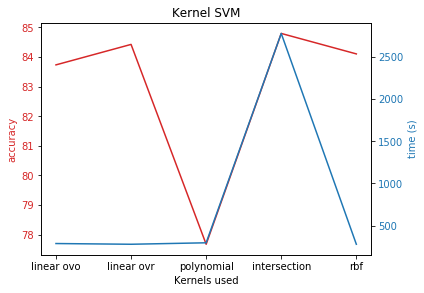

In [26]:
kernels = ["linear ovo", "linear ovr", "polynomial", "intersection", "rbf"]
plot_accuracy_vs_time(kernels, accuracy_list, time_list,
                      feature_name='Kernels used', title="Kernel SVM")

By looking at the graph, **RBF Kernel** seems to be the most suitable for the dataset as it reaches almost 85% accuracy, similar to linear ovr and the intersection kernel, but with requiring less computational cost

## Testing the Classifier

In this section, the final variables are set and the classifier will predict testing which is completly different from the training set.

In [35]:
# Determines total number of kps in an given image (set composed of 256x256px img)
sift_step_size = 16

# List providing scale values to compute at each kp
sift_scale = [16,32]

# Dense/Normal Sift 
dense = True

# Number of clusters in KMeans, size of codebook (words)
k_codebook = 1024

type_classifier = "SVM"

knn_dict ={
  "k_classifier": 5,
  "distance_method": "euclidean",
}

svm_dict ={
    "kernel": ["linear", "rbf", "poly", "precomputed"],
    "C_linear": 0.75,
    "C_linear2": 0.1,#0.8,
    "C_rbf": 10,#1,
    "C_poly": 100, #90,
    "C_inter": 1,
    "gamma": 0.1,#0.65,
    "degree": 1,
    "gamma_poly": 'auto',
}

# Number of pyramid levels used
pyramid_level = 1
# CrosValidation division kfold
number_splits = 3
# Intersection Kernel for SVM
intersection = False
# Distance method used in order to normalize bincounts for the BoW
norm_method = "l2"

# RBF
classifier_svm = init_classifier_svm(svm_dict)
classifier = classifier_svm[2][0]
clf_name = classifier_svm[2][1]

In [30]:
# Prepare files from DS for testing
test_images = open_pkl('test_images_filenames.dat')
test_labels = open_pkl('test_labels.dat')

Training the classifier with the chosen method and test its performance with a complete new set

In [36]:
(codebook, visual_words) = compute_BOW(train_images, dense, SIFTdetector, kpt,
                                               k_codebook, pyramid_level, norm_method)

# Compute kernel for classifier
# If not intersection, kernelMatrix = visual_words
kernel_matrix = compute_regular_kernel(visual_words, visual_words)

classifier.fit(kernel_matrix, train_labels)

visual_words_test = test_BOW(test_images, dense, SIFTdetector, kpt, k_codebook,
                             pyramid_level, codebook)

# Compute kernel for classifier
# If not intersection, kernelMatrix = visual_words
kernel_matrix_test = compute_regular_kernel(visual_words_test, visual_words)
                                                                   classifier)

The next cell classifies the test images a provides the confusion matrix with the classification for each class

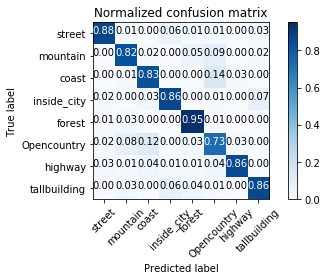

In [38]:
accuracy = 100 * classifier.score(kernel_matrix_test, test_labels)
predicted_labels = classifier.predict(kernel_matrix_test)
unique_labels = list(set(train_labels))

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_labels, labels=unique_labels)

# Plot confusion matrix
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=unique_labels,
                      normalize=True,
                      title='Normalized confusion matrix')

### Average accuracy

In [40]:
accuracy

84.38661710037175

## Evaluation
- SIFT variables need to be carefully adapted to each problem. It is also crucial in terms of time, being the step size the variable which fasters makes the comprem grow in cost.
- The codebook clustering improves the results when increased. Although, the computational cost when k = 2048 or more is too high and the accuracy is kind of stabilized. For this reason a k=1024 has been chosen. 
- The 'L2' and 'max' normalizations work better than the 'L1' normalization, being the two first pretty similar.
- The performance of the different kernels is similar, providing close results, except for the polynomial kernel, which does not reach 80%, wheares the other kernels do.
- In the linear kernel case, the one-vs-one and one-vs-rest methods have been implemented and the results are similar.